#I. IMPORT REQUIRED LIBRARIES

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import time
import pickle

# Machine Learning Model
!pip install catboost
from catboost import CatBoostClassifier

# Model Evaluation Metrics
from sklearn.metrics import (accuracy_score, f1_score, log_loss)

# Learning curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.6 MB/s eta 0:00:00


#II. UPLOAD DATA

In [ ]:
train_org = pd.read_csv("cluster_result.csv")
train = train_org.copy()

* The classification process began with utilizing training datasets, where the training data were the result of the mentioned clustering process (cluster_result.csv).

# III. TRAIN ML MODEL AND CROSS-VALIDATION

In [ ]:
def result_CatBoost(X_train, y_train, X_valid, y_valid):
    start_time = time.time()

    # Initialize CatBoost mode
    catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, l2_leaf_reg=3, early_stopping_rounds = 10, verbose=100, random_state=42)

    # Train the CatBoost model
    catboost_model.fit(X_train, y_train)

    # Predict probabilities for each class on the validation set
    y_pred_proba = catboost_model.predict_proba(X_valid)

    # Predict the class on the validation set
    y_pred = catboost_model.predict(X_valid)

    # Accuracy
    accuracy = accuracy_score(y_valid, y_pred)

    # F1-Score
    f1 = f1_score(y_valid, y_pred, average='macro')

    # Log oss
    logloss = log_loss(y_valid, y_pred_proba)

    end_time = time.time()
    execution_time = end_time - start_time

    print('Accuracy using Soft Voting: %.3f' % accuracy)
    print('F1 Score using Soft Voting: %.3f' % f1)
    print('Log Loss using Soft Voting: %.3f' % logloss)
    print("Thời gian thực thi:", time.strftime("%H:%M:%S", time.gmtime(execution_time)))
    return catboost_model

* The CatBoostClassifier, a leading Machine Learning algorithm known for handling categorical data without complex preprocessing and delivering high prediction accuracy, was selected for training.
* Configured with 500 iterations, a learning rate of 0.05, and l2_leaf_reg to control overfitting, the model also applied early stopping after 10 rounds of no improvement to optimize training.

In [ ]:
target_column = 'Cluster_Id'
y = train[target_column]
X = train.drop(target_column, axis=1)

In [ ]:
# Train and test a model on processed data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

* The dataset designated for training purposes is partitioned in such a manner that 80% is allocated for the training phase, while the remaining 20% is earmarked for cross-validation processes.
* This divisional schema is predicated upon the premise that it represents the most optimal ratio for such purposes.

In [ ]:
# Call the function with the corresponding data
catboost_model = result_CatBoost(X_train, y_train, X_valid, y_valid)

0:	learn: 1.5506325	total: 300ms	remaining: 2m 29s
100:	learn: 0.0137071	total: 21.7s	remaining: 1m 25s
200:	learn: 0.0077818	total: 43.9s	remaining: 1m 5s
300:	learn: 0.0073233	total: 1m 3s	remaining: 41.9s
400:	learn: 0.0070923	total: 1m 23s	remaining: 20.6s
499:	learn: 0.0069289	total: 1m 43s	remaining: 0us
Accuracy using Soft Voting: 0.997
F1 Score using Soft Voting: 0.996
Log Loss using Soft Voting: 0.007
Thời gian thực thi: 00:01:45


* Post-training, the model's performance on the cross-validation dataset was evaluated using Accuracy, F1-Score, and Log-loss metrics, showcasing CatBoost's impressive ability to accurately classify customer groups, aiding in effective cross-selling of insurance products.

# IV. SAVE THE TRAINED MODEL

In [ ]:
model_filename = 'trained_catboost_classifier.pkl'

# Pickle the trained model
with open(model_filename, 'wb') as file:
    pickle.dump(catboost_model, file)

print(f"Model saved to {model_filename}")

Model saved to trained_catboost_classifier.pkl


# V. APPLY INTO TEST DATASET

In [ ]:
# Load the pickled model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
test_org = pd.read_csv('test.csv')
test = test_org.copy()

In [ ]:
columns_to_keep = ['id', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium']
df_origin = test[columns_to_keep]

In [ ]:
df = df_origin.copy()
df['Vehicle_Age'] = df['Vehicle_Age'].replace({'< 1 Year': 1, '1-2 Year': 2, '> 2 Years': 3})
df['Vehicle_Damage'] = df['Vehicle_Damage'].replace({'No': 0, 'Yes': 1})

In [ ]:
y_pred_new = loaded_model.predict(df)
y_pred_new = y_pred_new.flatten()

submission_df = pd.DataFrame({
        'id': test['id'],
        'Cluster_ID': y_pred_new,
    })

submission_df.to_csv('submission_clusters.csv', index=False)

print("Kết quả dự đoán đã được lưu vào 'submission_clusters.csv'.")

Kết quả dự đoán đã được lưu vào 'submission_clusters.csv'.


In [ ]:
test_org = pd.read_csv('submission_clusters.csv')
test = test_org.copy()
test['Cluster_ID'].value_counts()

VVIP      24405
VIP #2    23704
VIP #3    23372
Common    22304
VIP #4    18617
VIP #1    14635
Name: Cluster_ID, dtype: int64

# V. LEARNING CURVES

In [ ]:
def plot_learning_curves(model, X_train, y_train, title="Learning Curves"):
    # Define the sizes of the training set and create learning curves
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=10, scoring=make_scorer(accuracy_score),
        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), verbose=1)

    # Calculate the mean and standard deviation of training and test scoreS
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    # Plot the standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Plot the mean scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[learning_curve] Training set sizes: [ 27439  89179 150918 212658 274398]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 45.1min finished


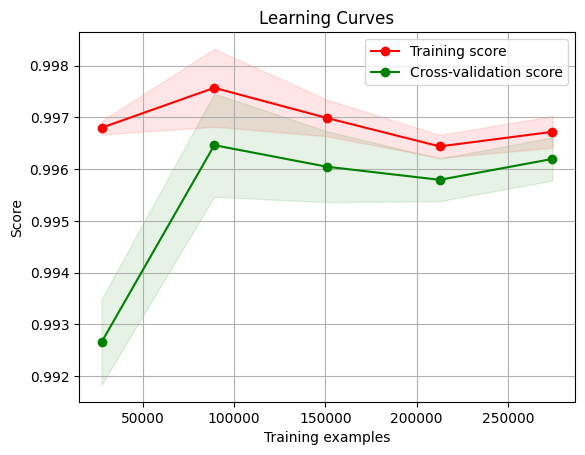

In [ ]:
plt = plot_learning_curves(catboost_model, X_train, y_train)
plt.show()

* Additionally, learning curves analysis assessed the model's generalizability and potential for overfitting or underfitting. The learning curves indicated strong training performance and generalization capability on new data, with both training and cross-validation scores exceeding 0.993, indicating excellent model performance on both datasets. The close and stable scores between training and cross-validation, along with an increase in cross-validation scores with more training data, highlighted the model's effectiveness without signs of overfitting and its improved performance with additional data. However, performance plateaued after a certain point, suggesting the model had learned most necessary information from the dataset. The narrow confidence intervals around the learning curves further indicated model stability and reliability for application to new data.